<a href="https://colab.research.google.com/github/hufsaim/T10402201/blob/master/notebook/Lab06_SimpleCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)

In [ ]:
!unzip covid19.zip

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [5]:
path_train = 'covid19/train/'
path_valid = 'covid19/valid/'

## 영상데이터에 대한 전처리과정 정의하기

In [6]:
train_transforms = transforms.Compose(
      [
          transforms.Grayscale(num_output_channels=1),
          transforms.Resize((64,64)),
          transforms.ToTensor(),
      ]
    )

## ImageFolder를 활용하여 data loader를 생성하기

In [7]:
batch_size = 32

trainset = torchvision.datasets.ImageFolder(root = path_train,transform=train_transforms)
validset = torchvision.datasets.ImageFolder(root = path_valid,transform=train_transforms)

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
validloader = torch.utils.data.DataLoader(validset,batch_size=batch_size,shuffle=False)

In [8]:
tgtnames = trainset.classes
print(tgtnames)

['covid19', 'normal', 'opacity']


In [9]:
print(len(trainset),len(validset))

1200 300


torch.Size([32, 1, 64, 64])
torch.Size([32])


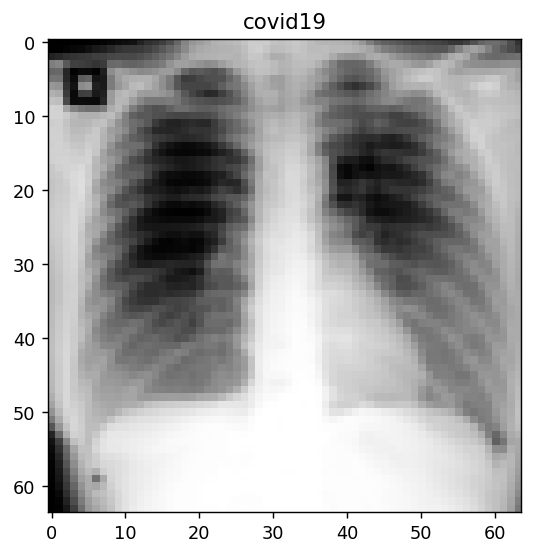

In [11]:
for X, y in trainloader:
  print(X.shape)
  print(y.shape)
  I = X[0][0].numpy()
  plt.figure(dpi=128)
  plt.imshow(I,cmap='gray')
  plt.title(tgtnames[y[0]])
  plt.show()
  break

## CNN model을 정의해보기

In [12]:
mycnn = torch.nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(in_features=6*32*32, out_features=120),
    nn.ReLU(),
    nn.Linear(120, 3),
)
mycnn = mycnn.to(device)
print(mycnn)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=6144, out_features=120, bias=True)
  (5): ReLU()
  (6): Linear(in_features=120, out_features=3, bias=True)
)


## Hyperparameter의 설정

In [13]:
# setting hyper-parameters
learning_rate = .1
num_epochs = 10

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(mycnn.parameters(),lr=learning_rate) # sgd

## Model 학습 진행

In [14]:
# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    mycnn.train()
    for X,y in trainloader:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat=mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    mycnn.eval()
    for X,y in validloader:
        X,y = X.to(device),y.to(device)
        y_hat = mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#        plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  1.0962351748817845
train accuracy:  0.3841666579246521
valid accuracy:  0.47999998927116394
epoch: 5 
train loss:  0.8181844510530171
train accuracy:  0.6566666960716248
valid accuracy:  0.4699999988079071


## 학습과정의 요약

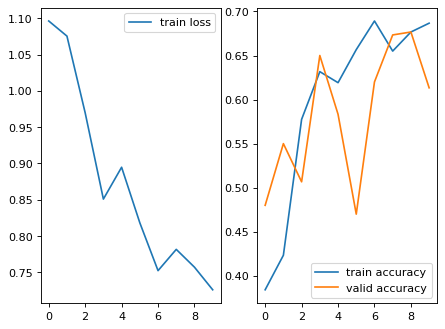

In [15]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()


## Validation set에 대한 개별결과 확인 (Inference)

In [16]:
from PIL import Image

In [17]:
N = 42
#validset.imgs[N][0]

covid19


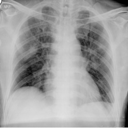

In [18]:
I = Image.open(validset.imgs[N][0])
X = train_transforms(I)
y = validset.targets[N]

print(tgtnames[y])
I


In [19]:
y_hat = mycnn(X.unsqueeze(1).to(device))
print(y_hat.cpu().detach().numpy())
y_hat = y_hat.argmax(dim=1)
print(f'prediction of mycnn: {tgtnames[y_hat.cpu().numpy()[0]]}')

[[ 2.4561768  -0.19004233 -2.248114  ]]
prediction of mycnn: covid19


## Validation set에 대한 결과 요약하기

In [20]:
y_list = np.array([])
y_hat_list = np.array([])
for X,y in validloader:
  y_hat = mycnn(X.to(device))
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

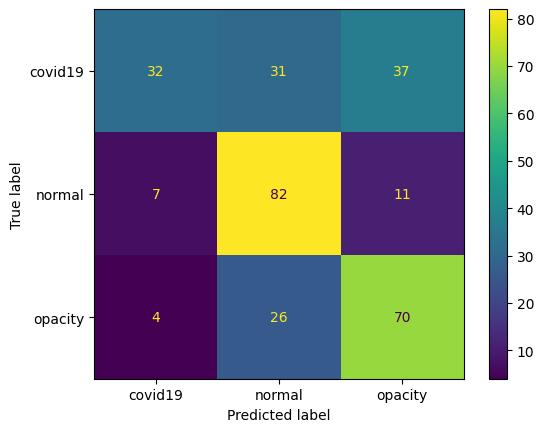

In [23]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])


## 유명한 CNN모델들을 활용

In [28]:
mycnn = torchvision.models.vgg11()
mycnn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

- input layer, output layer 를 나의 데이터에 맞추어 변경하기

In [31]:
mycnn.features[0] = nn.Conv2d(1,64,3,1,1)
mycnn.classifier[6] = nn.Linear(in_features=4096, out_features=3, bias=True)
mycnn = mycnn.to(device)
mycnn

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [36]:
# setting hyper-parameters
learning_rate = .01
num_epochs = 30

# loss function and algorithm
loss = torch.nn.CrossEntropyLoss() # loss
alg = torch.optim.SGD(mycnn.parameters(),lr=learning_rate) # sgd

# training the model
loss_train = np.array([])
accs_train = np.array([])
accs_valid = np.array([])

for epoch in range(num_epochs):
    i=0
    l_epoch = 0
    correct = 0
    mycnn.train()
    for X,y in trainloader:
        i=i+1
        X,y = X.to(device),y.to(device)
        y_hat = mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()
        l=loss(y_hat,y)
        l_epoch+=l
        alg.zero_grad()
        l.backward()
        alg.step()

    loss_train = np.append(loss_train,l_epoch.cpu().detach().numpy()/i)
    accs_train = np.append(accs_train,correct.cpu()/len(trainset))

    correct = 0
    mycnn.eval()
    for X,y in validloader:
        X,y = X.to(device),y.to(device)
        y_hat = mycnn(X)
        correct += (y_hat.argmax(dim=1)==y).sum()

    accs_valid = np.append(accs_valid,correct.cpu()/len(validset))

    plt.figure(2,dpi=80)
    plt.subplot(121)
    plt.plot(loss_train,label='train loss')
    plt.legend(loc='upper right')
    plt.subplot(122)
    plt.plot(accs_train,label='train accuracy')
    plt.plot(accs_valid,label='valid accuracy')
    plt.legend(loc='upper left')
    plt.title('epoch: %d '%(epoch))
    plt.savefig('loss_curve.png')
#        plt.show()
    plt.close(2)

    if epoch%5 == 0:
        print('epoch: %d '%(epoch))
        print('train loss: ',loss_train[-1])
        print('train accuracy: ',accs_train[-1])
        print('valid accuracy: ',accs_valid[-1])

epoch: 0 
train loss:  0.8243453377171567
train accuracy:  0.6458333134651184
valid accuracy:  0.6499999761581421
epoch: 5 
train loss:  0.6518391057064659
train accuracy:  0.7300000190734863
valid accuracy:  0.5766666531562805
epoch: 10 
train loss:  0.6160630175941869
train accuracy:  0.7591666579246521
valid accuracy:  0.7666666507720947
epoch: 15 
train loss:  0.525925686484889
train accuracy:  0.7866666913032532
valid accuracy:  0.7400000095367432
epoch: 20 
train loss:  0.47305870056152344
train accuracy:  0.8174999952316284
valid accuracy:  0.7733333110809326
epoch: 25 
train loss:  0.42492976941560445
train accuracy:  0.8208333253860474
valid accuracy:  0.7766666412353516


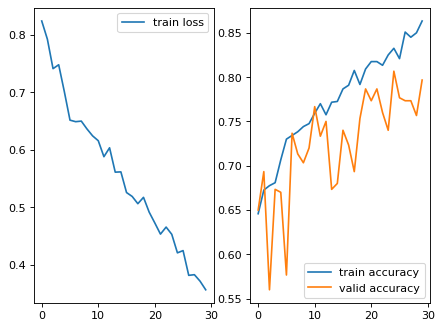

In [37]:
plt.figure(2,dpi=80)
plt.subplot(121)
plt.plot(loss_train,label='train loss')
plt.legend(loc='upper right')
plt.subplot(122)
plt.plot(accs_train,label='train accuracy')
plt.plot(accs_valid,label='valid accuracy')
plt.legend(loc='lower right')
plt.show()

In [38]:
y_list = np.array([])
y_hat_list = np.array([])
for X,y in validloader:
  y_hat = mycnn(X.to(device))
  y_hat = y_hat.argmax(dim=1)
  y_list = np.append(y_list,y)
  y_hat_list = np.append(y_hat_list,y_hat.cpu().numpy())
print(classification_report(
    y_list,
    y_hat_list,
    target_names=tgtnames))

              precision    recall  f1-score   support

     covid19       0.95      0.71      0.81       100
      normal       0.90      0.74      0.81       100
     opacity       0.66      0.94      0.77       100

    accuracy                           0.80       300
   macro avg       0.84      0.80      0.80       300
weighted avg       0.84      0.80      0.80       300



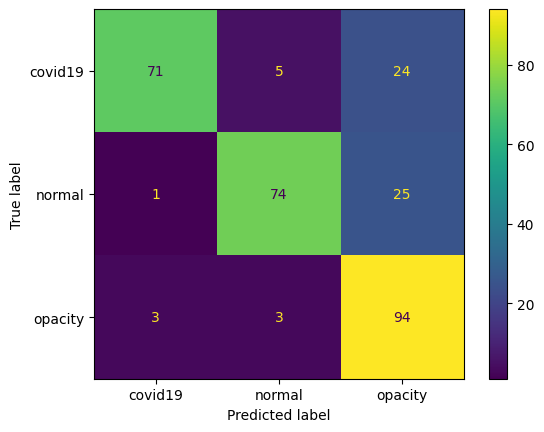

In [39]:
cm = confusion_matrix(
    y_list,
    y_hat_list,
#    normalize='true',
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=tgtnames,
)
disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])
